In [3]:
import zipfile
zipfile.ZipFile('tabular-playground-series-jan-2021.zip').extractall('.')

In [1]:
!pip install -U pip
!pip install seaborn
!pip install scikit-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Preprocessing data

            id     cont1     cont2     cont3     cont4     cont5     cont6  \
0            1  0.670390  0.811300  0.643968  0.291791  0.284117  0.855953   
1            3  0.388053  0.621104  0.686102  0.501149  0.643790  0.449805   
2            4  0.834950  0.227436  0.301584  0.293408  0.606839  0.829175   
3            5  0.820708  0.160155  0.546887  0.726104  0.282444  0.785108   
4            8  0.935278  0.421235  0.303801  0.880214  0.665610  0.830131   
...        ...       ...       ...       ...       ...       ...       ...   
299995  499995  0.216974  0.735265  0.648648  0.255387  0.616353  0.345197   
299996  499996  0.545799  0.165139  0.220966  0.190053  0.359362  0.386336   
299997  499997  0.284401  0.841542  0.957585  0.340383  0.396279  0.330376   
299998  499998  0.481900  0.622346  0.540032  0.823118  0.283066  0.434283   
299999  499999  0.486632  0.230090  0.543587  0.263878  0.279118  0.636295   

           cont7     cont8     cont9    cont10    cont11    con

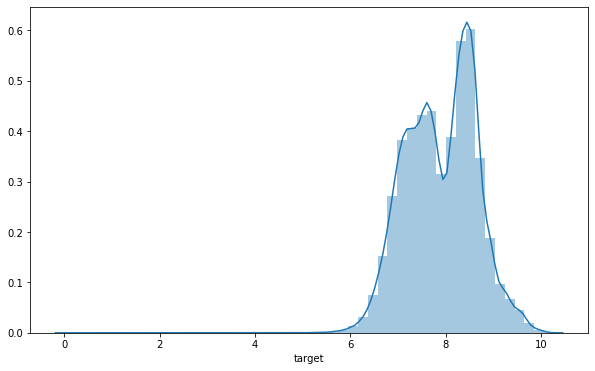

In [24]:
df = pd.read_csv('tabular-playground-series-jan-2021/train.csv')
test_df = pd.read_csv('tabular-playground-series-jan-2021/test.csv')
print(df)

features_names2 = df.drop(['id'], axis=1).columns.values
features_names = df.drop(['id', 'target'], axis=1).columns.values
print(features_names)

plt.figure(figsize=(10, 6))
sns.distplot(df['target'], kde=True)
plt.show()

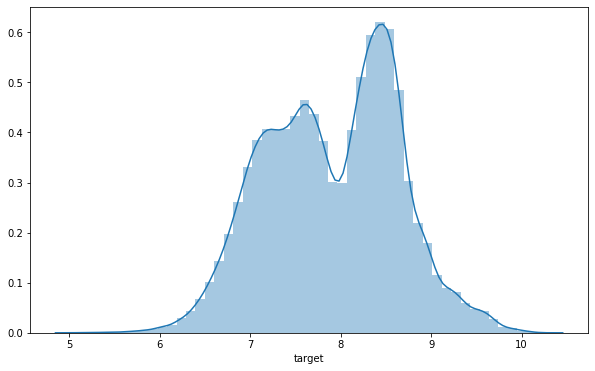

In [4]:
df.drop(df[df['target'] <= 5].index, axis=0, inplace=True)
plt.figure(figsize=(10, 6))
sns.distplot(df['target'], kde=True)
plt.show()

In [5]:
scaler = StandardScaler()
scaler.fit(df[features_names])

target = df['target'].values
data = scaler.transform(df[features_names])
test = scaler.transform(test_df.drop('id', axis=1).values)

X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.3, random_state=17, shuffle=False)

# Regression

In [6]:
#LinearRegression
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
print(reg_model.score(X_val, y_val))

0.018558029430524092


In [10]:
#RandomForest
forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train)
print(forest_model.score(X_val, y_val))

0.06485027792298359


In [25]:
correlation_matrix = df[features_names2].corr()
print(correlation_matrix)
print(np.linalg.det(correlation_matrix))
print()

u, s, v = np.linalg.svd(correlation_matrix)
sigmas = pd.DataFrame(data=s, columns=['singular values'])
print(sigmas)

           cont1     cont2     cont3     cont4     cont5     cont6     cont7  \
cont1   1.000000 -0.080170 -0.419712  0.273705 -0.059012  0.698556  0.341478   
cont2  -0.080170  1.000000  0.334487 -0.005533  0.150737  0.023692  0.116222   
cont3  -0.419712  0.334487  1.000000 -0.329131  0.060931 -0.300509  0.106904   
cont4   0.273705 -0.005533 -0.329131  1.000000  0.123526  0.152752 -0.077045   
cont5  -0.059012  0.150737  0.060931  0.123526  1.000000 -0.179084 -0.241272   
cont6   0.698556  0.023692 -0.300509  0.152752 -0.179084  1.000000  0.541975   
cont7   0.341478  0.116222  0.106904 -0.077045 -0.241272  0.541975  1.000000   
cont8   0.373340  0.081049 -0.309783  0.324784  0.010438  0.415008  0.150403   
cont9   0.794003 -0.046769 -0.406743  0.261927 -0.071764  0.716613  0.341759   
cont10  0.725040  0.035101 -0.289756  0.204139 -0.102531  0.770628  0.465418   
cont11  0.565717  0.126024 -0.075415  0.063961 -0.222244  0.737495  0.672188   
cont12  0.600041  0.092642 -0.103735  0.

# Regularization

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=17)

alphas = np.logspace(-7, -1, 200)

lasso_scores = np.array([cross_val_score(Lasso(alpha), X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error').mean() for alpha in alphas])
ridge_scores = np.array([cross_val_score(Ridge(alpha), X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error').mean() for alpha in alphas])

best_lasso_alpha = alphas[lasso_scores.argmax()]
print(best_lasso_alpha)
best_ridge_alpha = alphas[ridge_scores.argmax()]
print(best_ridge_alpha)

3.2176417502507353e-06
0.1


In [10]:
lasso_model = Lasso(alpha=best_lasso_alpha)
lasso_model.fit(X_train, y_train)
print(lasso_model.score(X_val, y_val))

ridge_model = Ridge(alpha=best_ridge_alpha)
ridge_model.fit(X_train, y_train)
print(ridge_model.score(X_val, y_val))

0.018558010676761327
0.01855802861187361


In [11]:
def print_errors(model):
    train_loss = mean_squared_error(model.predict(X_train), y_train, squared=False)
    val_loss = mean_squared_error(model.predict(X_val), y_val, squared=False)
    print(f'Train RMSE = {train_loss}')
    print(f'Valid RMSE = {val_loss}')

In [12]:
print('Lasso:')
print_errors(lasso_model)
print('Ridge:')
print_errors(ridge_model)

Lasso:
Train RMSE = 0.7260876198956822
Valid RMSE = 0.7247334616164378
Ridge:
Train RMSE = 0.7260876196566183
Valid RMSE = 0.7247334549944591


In [14]:
scaler = StandardScaler()
scaler.fit(df[features_names])

target = df['target'].values
data = scaler.transform(df[features_names])
test = scaler.transform(test_df.drop('id', axis=1).values)

#normalising data
train_data = (data-data.mean())/data.std()
test_data = (test-test.mean())/test.std()
y_data = (target-target.mean())/target.std()

X_train, X_val, y_train, y_val = train_test_split(train_data, y_data, test_size=0.3, random_state=17, shuffle=False)

In [15]:
reg_model.fit(X_train, y_train)
print(reg_model.score(X_val, y_val))

0.018558029430524203


In [19]:
forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train)
print(forest_model.score(X_val, y_val))

0.06597521058085187


In [16]:
lasso_model.fit(X_train, y_train)
print(lasso_model.score(X_val, y_val))
print('Lasso:')
print_errors(lasso_model)

0.018558015361069047
Lasso:
Train RMSE = 0.9911851708394551
Valid RMSE = 0.9893366016400368


In [17]:
ridge_model.fit(X_train, y_train)
print(ridge_model.score(X_val, y_val))
print('Ridge:')
print_errors(ridge_model)

0.0185580286118735
Ridge:
Train RMSE = 0.9911851706640972
Valid RMSE = 0.9893365949613405


# Submission

In [ ]:
lasso_model = Lasso(alpha=best_lasso_alpha).fit(data, target)
ridge_model = Ridge(alpha=best_ridge_alpha).fit(data, target)

In [ ]:
id_test = test_df['id']
lasso_pred = lasso_model.predict(test)
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = lasso_pred
print(sub)
sub.to_csv('submission_lasso.csv', index=False)

In [ ]:
id_test = test_df['id']
ridge_pred = ridge_model.predict(test)
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = lasso_pred
print(sub)
sub.to_csv('submission_ridge.csv', index=False)

In [27]:
forest_model.fit(data, target)
id_test = test_df['id']
forest_pred = forest_model.predict(test)
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = forest_pred
print(sub)
sub.to_csv('submission_forest.csv', index=False)

            id    target
0            0  8.029352
1            2  7.745390
2            6  8.090802
3            7  8.154204
4           10  7.894398
...        ...       ...
199995  499984  8.157196
199996  499985  7.995825
199997  499987  8.344128
199998  499988  7.904461
199999  499990  7.913550

[200000 rows x 2 columns]
